# Plotting with ASTE

In [1]:
import numpy as np
from matplotlib import cm
import cartopy as cart

In [2]:
# those modules are developped at LDEO 
import xmitgcm
import MITgcm_recipes

In [3]:
# ASTE grid information
# we need extra metadata for xmitgcm to figure it out
astemd = xmitgcm.utils.get_extra_metadata(domain='aste', nx=270)

In [4]:
# ASTE run from An
dir_aste_diags = '/local/data/artemis/simulations/ASTE/r1/diags/'
dir_aste_grid  = '/local/data/artemis/simulations/ASTE/r1/grid/'

ds_aste = xmitgcm.open_mdsdataset(dir_aste_diags, prefix=['state_3d_set1',
                                                          'trsp_3d_set1'],
                                  geometry='llc',nx=270,read_grid=True,
                                  grid_dir=dir_aste_grid,extra_metadata=astemd, 
                                  delta_t=1200, ref_date='2002-1-1 0:0:0')

## Scalar variables

Let's plot the SST for december 2004

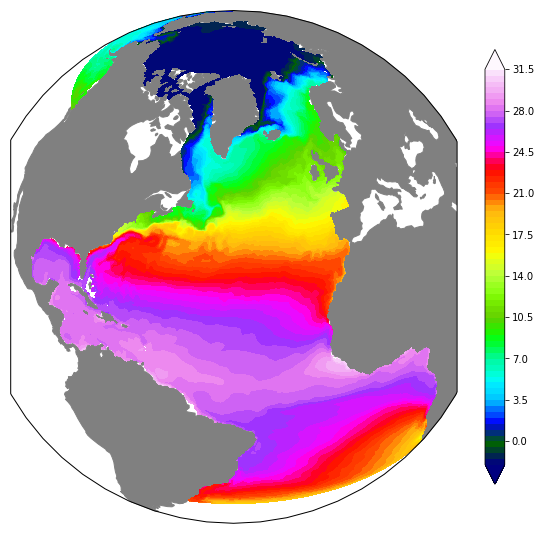

In [5]:
sst_2004_12 = ds_aste['THETA'].sel(k=0, time='2004-12')

dict_plt_sst = {'figsize': [10, 10], 'vmin': -2,'vmax': 32, 
                'contours': np.arange(-2,32,0.5), 
                'cmap': cm.gist_ncar, 'cbarsize': 0.8, 
                'title': 'SST Dec 2004'}

fig = MITgcm_recipes.plot_ASTE_pyresample(sst_2004_12, 
                                          dict_plt_sst, 
                                          proj=cart.crs.Orthographic(
                                              central_longitude=-40,
                                              central_latitude=35))

## Velocities

First we need to rotate the velocities. This will use xgcm eventually when issue
https://github.com/xgcm/xgcm/issues/126 is fixed. For now it uses a dirty code bit. To allow xgcm to perform operation on llc grid, we need to provide how the faces connect to each other.

In [6]:
face_connections = MITgcm_recipes.utils.define_faces_connection_ASTE()

In [7]:
u1 = ds_aste['UVELMASS'].sel(k=0, time='2004-12')
v1 = ds_aste['VVELMASS'].sel(k=0, time='2004-12')

u_geo, v_geo = MITgcm_recipes.spatial.rotate_llc_to_geo(u1, v1, ds_aste, 
                                                        face_connections)

Add back to the dataset to keep the grid info.

In [8]:
ds_aste['u_geo'] = u_geo
ds_aste['v_geo'] = v_geo

### zonal velocity

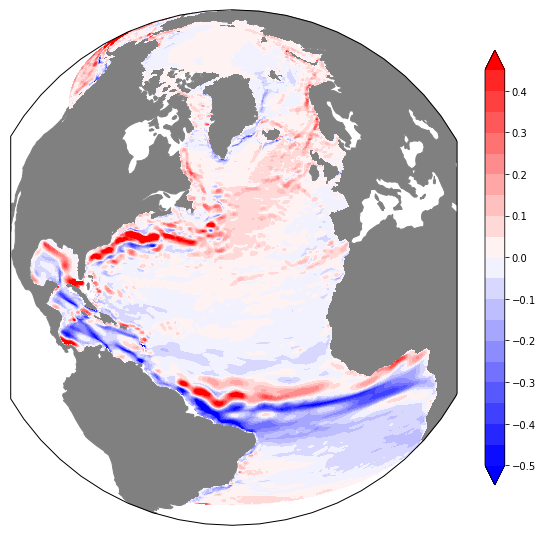

In [9]:
dict_plt_vel = {'figsize': [10, 10], 'vmin': -0.5,'vmax': 0.5, 
                'contours': np.arange(-0.5,0.5,0.05), 
                'cmap': cm.bwr, 'cbarsize': 0.8, 
                'title': ''}

fig = MITgcm_recipes.plot_ASTE_pyresample(u_geo, 
                                          dict_plt_vel, 
                                          proj=cart.crs.Orthographic(
                                              central_longitude=-40,
                                              central_latitude=35))

### Meridional velocity

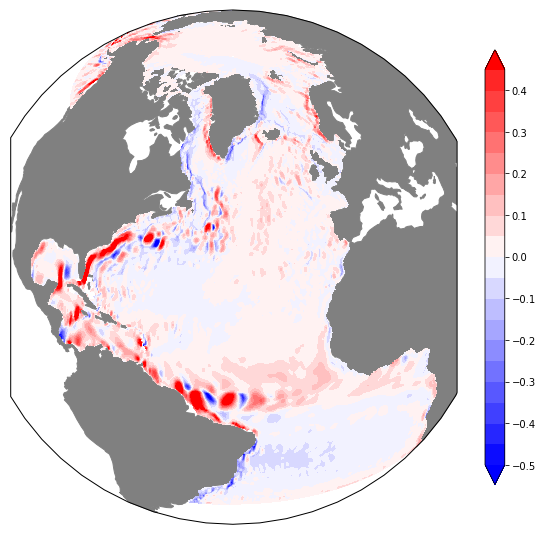

In [10]:
dict_plt_vel = {'figsize': [10, 10], 'vmin': -0.5,'vmax': 0.5, 
                'contours': np.arange(-0.5,0.5,0.05), 
                'cmap': cm.bwr, 'cbarsize': 0.8, 
                'title': ''}

fig = MITgcm_recipes.plot_ASTE_pyresample(v_geo, 
                                          dict_plt_vel, 
                                          proj=cart.crs.Orthographic(
                                              central_longitude=-40,
                                              central_latitude=35))

### Total velocity

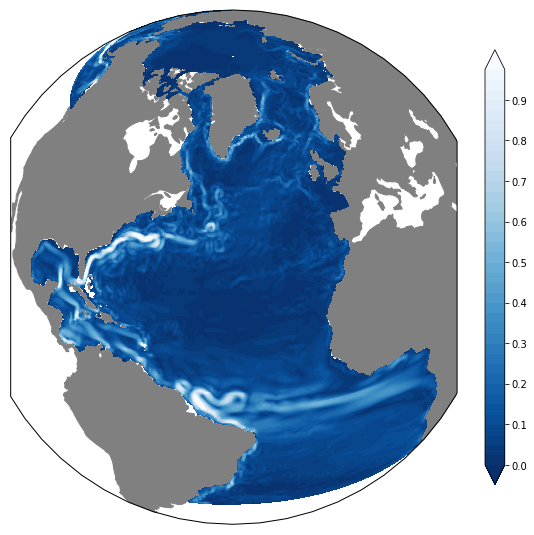

In [13]:
dict_plt_vel = {'figsize': [10, 10], 'vmin': 0,'vmax': 1, 
                'contours': np.arange(0.,1.,0.025), 
                'cmap': cm.Blues_r, 'cbarsize': 0.8, 
                'title': ''}

fig = MITgcm_recipes.plot_ASTE_pyresample(np.sqrt(u_geo**2 + v_geo**2), 
                                          dict_plt_vel, 
                                          proj=cart.crs.Orthographic(
                                              central_longitude=-40,
                                              central_latitude=35))